In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from preprocess import return_preprocessed_df

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
df = return_preprocessed_df(to_lowercase = False, remove_punc = False, remove_stop_words = False)

In [3]:
df.head()

,titles,category,Label
0,"Trentino, femministe chiedono l'abbattimento d...",cronaca,1
1,"""Voglio essere come lui!"" Bambino guarda video...",cronaca,1
2,"""Vorrei staccare la spina"". Sospeso medico ria...",cronaca,1
3,"Gatta muore al pronto soccorso per animali, ve...",cronaca,1
4,"Bologna, Comune installa sui semafori piccioni...",cronaca,1


In [4]:
sentences = df['titles'].values
labels = df['Label'].values

training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(sentences, labels, test_size=0.2)

vocab_size = 1000
embedding_dim = 16
max_length = 32
trunc_type='post'
padding_type='post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    Conv1D(16, 1, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()

history = model.fit(
    training_padded, training_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels),
    #callbacks=[early_stopping],
    verbose=2
)

end_time = time.time()

training_time = (end_time - start_time)

print(f"\nTraining time: {training_time} seconds.")

print()

loss, accuracy = model.evaluate(testing_padded, testing_labels, verbose=2)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
388/388 - 3s - 8ms/step - accuracy: 0.7338 - loss: 0.5189 - val_accuracy: 0.8356 - val_loss: 0.3710
Epoch 2/10
388/388 - 1s - 3ms/step - accuracy: 0.8634 - loss: 0.3125 - val_accuracy: 0.8504 - val_loss: 0.3309
Epoch 3/10
388/388 - 1s - 3ms/step - accuracy: 0.8854 - loss: 0.2597 - val_accuracy: 0.8627 - val_loss: 0.3117
Epoch 4/10
388/388 - 1s - 2ms/step - accuracy: 0.8994 - loss: 0.2366 - val_accuracy: 0.8588 - val_loss: 0.3088
Epoch 5/10
388/388 - 1s - 2ms/step - accuracy: 0.9070 - loss: 0.2222 - val_accuracy: 0.8656 - val_loss: 0.3090
Epoch 6/10
388/388 - 1s - 2ms/step - accuracy: 0.9151 - loss: 0.2092 - val_accuracy: 0.8640 - val_loss: 0.3132
Epoch 7/10
388/388 - 1s - 3ms/step - accuracy: 0.9213 - loss: 0.1978 - val_accuracy: 0.8646 - val_loss: 0.3188
Epoch 8/10
388/388 - 1s - 2ms/step - accuracy: 0.9263 - loss: 0.1881 - val_accuracy: 0.8672 - val_loss: 0.3221
Epoch 9/10
388/388 - 1s - 3ms/step - accuracy: 0.9316 - loss: 0.1780 - val_accuracy: 0.8691 - val_loss: 0.3298
E

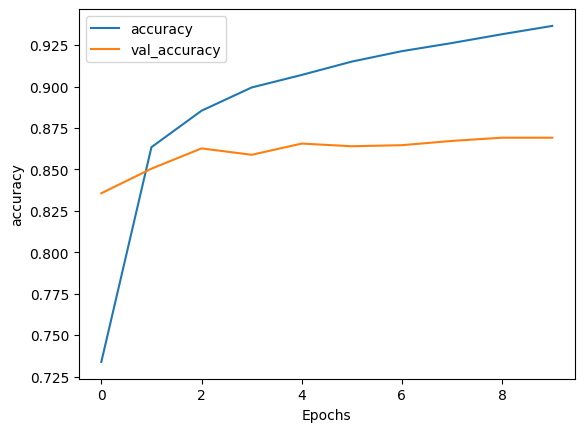

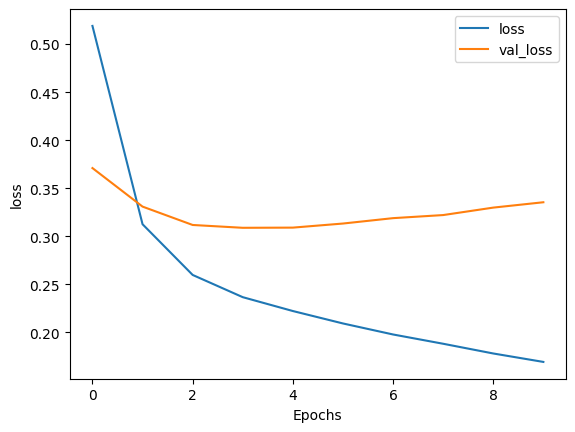

In [5]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

97/97 - 0s - 2ms/step - accuracy: 0.8691 - loss: 0.3354
Test Accuracy: 0.8691167235374451
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1968
           1       0.83      0.81      0.82      1134

    accuracy                           0.87      3102
   macro avg       0.86      0.86      0.86      3102
weighted avg       0.87      0.87      0.87      3102


ROC-AUC: 0.939608919071995


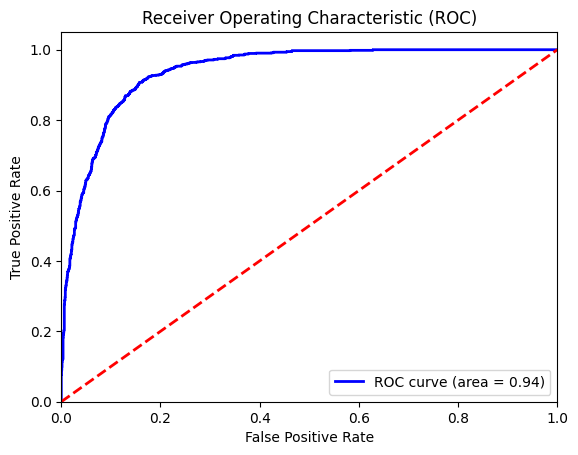

In [6]:
loss, accuracy = model.evaluate(testing_padded, testing_labels, verbose=2)
print(f'Test Accuracy: {accuracy}')

y_pred_prob = model.predict(testing_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

report = classification_report(testing_labels, y_pred)
print("\nClassification Report:\n", report)

roc_auc = roc_auc_score(testing_labels, y_pred_prob)
print(f"\nROC-AUC: {roc_auc}")

fpr, tpr, thresholds = roc_curve(testing_labels, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()